--- 위험 등급별 데이터 개수 ---
Risk_Level
0    199664
1    109920
2     45985
Name: count, dtype: int64

-> 모델 학습 중...
-> 학습 완료!

--- 모델 성능 평가 (Accuracy) ---
정확도: 0.5604

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

         Low       0.56      1.00      0.72     39933
      Medium       0.29      0.00      0.01     21984
        High       0.40      0.00      0.00      9197

    accuracy                           0.56     71114
   macro avg       0.42      0.33      0.24     71114
weighted avg       0.46      0.56      0.41     71114



<Figure size 1000x600 with 0 Axes>

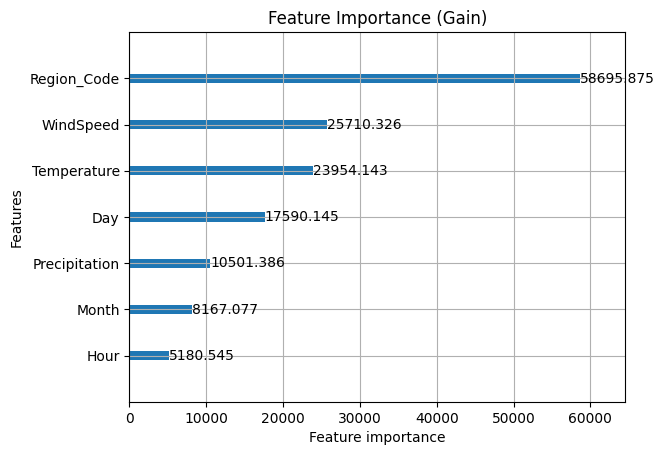

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================================
# 1. 데이터 로드 및 타겟 생성
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# [Target 생성] 사고 심각도 점수 계산 (가중치 부여)
# 사망: 10점, 중상: 5점, 경상: 3점, 부상신고: 1점
df['Risk_Score'] = (df['사망자수'] * 10) + (df['중상자수'] * 5) + (df['경상자수'] * 3) + (df['부상신고자수'] * 1)

# 점수 분포를 기반으로 3등급(Low, Medium, High)으로 분류
# 하위 40% -> 0 (Low), 40~80% -> 1 (Medium), 상위 20% -> 2 (High)
# 실제 데이터 분포를 보고 분위수(Quantile)로 나누는 것이 합리적임
bins = [-1, df['Risk_Score'].quantile(0.4), df['Risk_Score'].quantile(0.8), np.inf]
labels = [0, 1, 2] # 0: 안전/경미, 1: 주의, 2: 위험
df['Risk_Level'] = pd.cut(df['Risk_Score'], bins=bins, labels=labels).astype(int)

print("--- 위험 등급별 데이터 개수 ---")
print(df['Risk_Level'].value_counts().sort_index())

# ========================================================
# 2. Feature Engineering (모델 입력 변수 정리)
# ========================================================
# 학습에 사용할 Feature 선택 (예측 시점에 알 수 있는 정보만!)
features = [
    'Month', 'Hour', 'Day',          # 시간 정보
    'Region_Code', 'Population_Feature', # 공간 정보
    'Temperature', 'Precipitation', 'WindSpeed', # 기상 정보
    '주야' # 주야 정보 (Hour가 있지만 보조 정보로 활용)
]

X = df[features].copy()
y = df['Risk_Level']

# 범주형 변수 인코딩 (주야)
le = LabelEncoder()
X['주야'] = le.fit_transform(X['주야'])

# 결측치 처리 (간단히 0이나 평균으로 채움)
X = X.fillna(0)

# ========================================================
# 3. 데이터 분할 및 모델 학습
# ========================================================
# 학습용(80%) / 테스트용(20%) 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LightGBM 모델 생성 및 학습
model = lgb.LGBMClassifier(
    n_estimators=500,    # 나무의 개수
    learning_rate=0.05,  # 학습률
    max_depth=10,        # 나무 깊이
    random_state=42,
    verbose=-1           # 경고 메시지 끄기
)

print("\n-> 모델 학습 중...")
model.fit(X_train, y_train)
print("-> 학습 완료!")

# ========================================================
# 4. 성능 평가
# ========================================================
y_pred = model.predict(X_test)

print("\n--- 모델 성능 평가 (Accuracy) ---")
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# ========================================================
# 5. 변수 중요도 시각화 (Feature Importance)
# ========================================================
# 어떤 변수가 사고 위험 예측에 가장 큰 영향을 미쳤는가?
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10, importance_type='gain', title='Feature Importance (Gain)')
plt.show()

--- 타겟 클래스 분포 확인 (개선 후) ---
Risk_Level
0    199664
1    109920
2     45985
Name: count, dtype: int64

-> 모델 학습 중 (Balanced Mode)...
-> 학습 완료!

--- 모델 성능 평가 ---
정확도(Accuracy): 0.3676
Macro F1-Score: 0.3335

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

         Low       0.59      0.41      0.49     39933
      Medium       0.32      0.25      0.28     21984
        High       0.16      0.44      0.23      9197

    accuracy                           0.37     71114
   macro avg       0.36      0.37      0.33     71114
weighted avg       0.45      0.37      0.39     71114



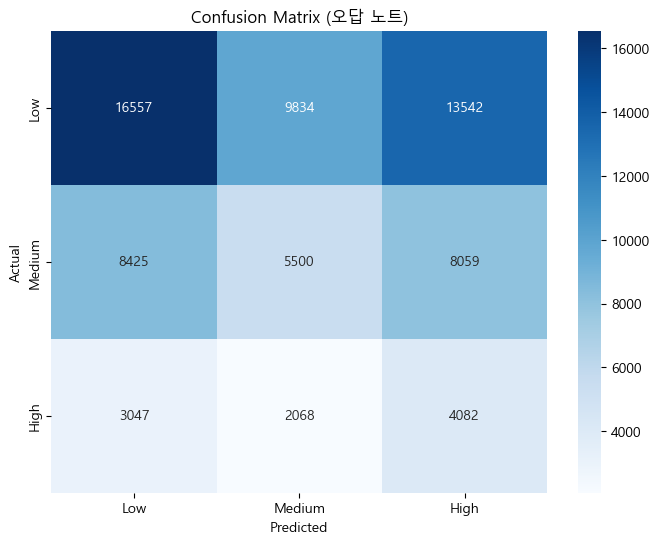

<Figure size 1000x600 with 0 Axes>

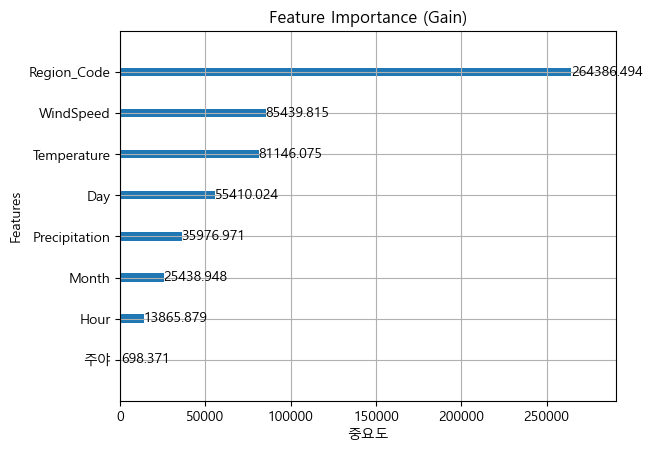

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# [Target 생성] 사고 심각도 점수 계산
# 단순 점수 합산이 아니라, 사망 사고에 더 큰 가중치를 부여하여 '위험'을 강조
# 사망(10) / 중상(5) / 경상(3) / 부상신고(1)
df['Risk_Score'] = (df['사망자수'] * 10) + (df['중상자수'] * 5) + (df['경상자수'] * 3) + (df['부상신고자수'] * 1)

# [개선] 데이터 불균형 완화를 위한 Target 정의 수정
# 분위수(Quantile) 대신, 실제 점수 기준으로 '의미 있는' 위험 구간 설정 시도
# 예: 점수 3이하(단순 경상 1명) -> Low, 점수 4~6 -> Medium, 7이상 -> High
# 이렇게 하면 '사망'이나 '중상'이 낀 사고는 무조건 High/Medium으로 올라감
def assign_risk_level(score):
    if score <= 3: return 0 # Low (경상 1명 이하 수준)
    elif score <= 6: return 1 # Medium (중상 1명 또는 경상 2명 수준)
    else: return 2 # High (사망 또는 다중 추돌)

df['Risk_Level'] = df['Risk_Score'].apply(assign_risk_level)

print("--- 타겟 클래스 분포 확인 (개선 후) ---")
print(df['Risk_Level'].value_counts().sort_index())

# ========================================================
# 2. Feature Engineering
# ========================================================
# 범주형 변수는 LightGBM의 categorical_feature 기능을 활용하기 위해 category 타입으로 변환
categorical_features = ['Region_Code', '주야']
for col in categorical_features:
    df[col] = df[col].astype('category')

# 모델 입력 변수 (X)
features = [
    'Month', 'Hour', 'Day', 
    'Region_Code', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Risk_Level']

# [수정] 결측치 처리 전, category 타입 컬럼 처리 주의
# category 타입 컬럼에 없는 값(0)을 채우려 하면 에러 발생함.
# 수치형 컬럼만 선택해서 fillna를 하거나, category 타입을 잠시 풀었다가 다시 설정해야 함.

# 1. 수치형 컬럼 결측치 채우기 (0으로)
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# 2. 범주형 컬럼 결측치 처리 (새로운 카테고리 'Unknown' 추가 방식 권장, 여기서는 최빈값 또는 그대로 둠)
# LightGBM은 범주형 변수의 NaN을 알아서 처리해주므로 굳이 0으로 채울 필요가 없을 수도 있음.
# 만약 꼭 채워야 한다면:
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].cat.add_categories(['Unknown']).fillna('Unknown')

# ========================================================
# 3. 데이터 분할 및 모델 학습 (Class Weight 적용)
# ========================================================
# Stratify를 사용하여 Train/Test 세트의 클래스 비율 유지
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# [핵심 개선] class_weight='balanced' 설정
# 데이터가 적은 클래스(High/Medium)에 더 높은 가중치를 부여하여 학습
model = lgb.LGBMClassifier(
    n_estimators=1000,   # 반복 횟수 증가
    learning_rate=0.03,  # 학습률을 낮춰서 더 꼼꼼하게 학습
    max_depth=15,
    num_leaves=31,
    class_weight='balanced', # 불균형 데이터 해결의 핵심!
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\n-> 모델 학습 중 (Balanced Mode)...")
# 범주형 변수 지정하여 학습 (성능 향상)
model.fit(X_train, y_train, categorical_feature=['Region_Code', '주야'])
print("-> 학습 완료!")

# ========================================================
# 4. 성능 평가 (혼동 행렬 시각화 추가)
# ========================================================
y_pred = model.predict(X_test)

print("\n--- 모델 성능 평가 ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print(f"Macro F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}") # 불균형 데이터에선 이게 더 중요

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# [추가] 혼동 행렬 시각화
# 모델이 어떤 클래스를 헷갈려하는지 직관적으로 확인
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (오답 노트)')
plt.show()

# ========================================================
# 5. 변수 중요도 (Feature Importance)
# ========================================================
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)', xlabel='중요도')
plt.show()

--- 타겟 클래스 분포 (0: 일반, 1: 고위험) ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> 모델 학습 중 (Binary Classification, Weight: 3.28)...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.541712
Early stopping, best iteration is:
[82]	valid_0's auc: 0.54185
-> 학습 완료!

--- 모델 성능 평가 ---
정확도(Accuracy): 0.7399
F1-Score (High Risk): 0.1376
ROC-AUC Score: 0.5419

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

     General       0.77      0.94      0.85     54501
      Severe       0.31      0.09      0.14     16613

    accuracy                           0.74     71114
   macro avg       0.54      0.51      0.49     71114
weighted avg       0.66      0.74      0.68     71114



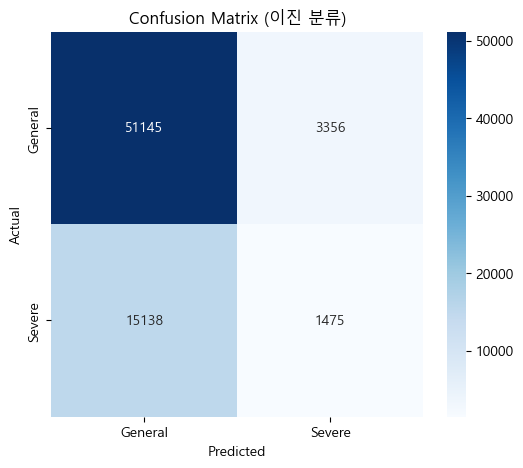

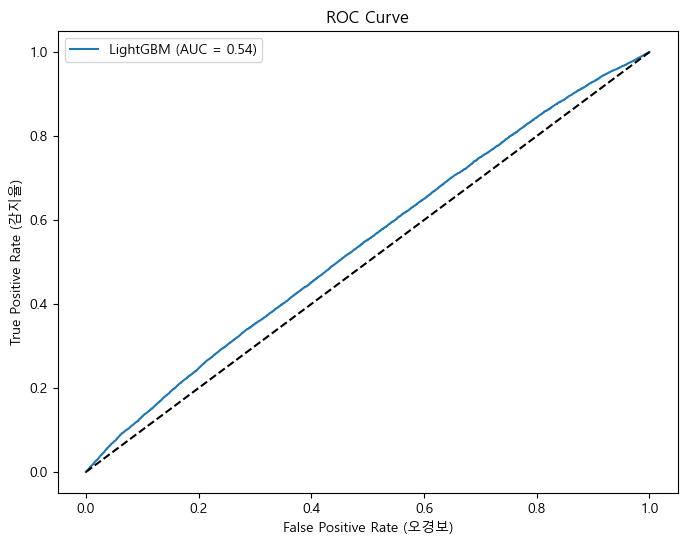

<Figure size 1000x600 with 0 Axes>

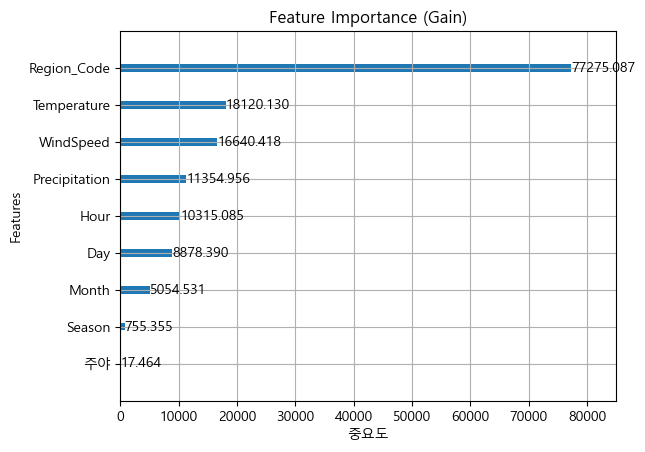

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성 (이진 분류로 변경)
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# [핵심 수정] 타겟 정의를 3단계 -> 2단계(Binary)로 단순화
# 목표: "치명적인 사고(사망/중상)를 예측할 수 있는가?"
# 0: 경상/부상신고 (일반 사고)
# 1: 사망/중상 (고위험 사고)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 (0: 일반, 1: 고위험) ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering
# ========================================================
# 범주형 변수 설정
categorical_features = ['Region_Code', '주야']
for col in categorical_features:
    df[col] = df[col].astype('category')

# 모델 입력 변수 (X)
# 파생 변수 추가: 계절 등
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3) # 1:겨울, 2:봄, 3:여름, 4:가을
features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 수치형 컬럼 결측치 채우기 (0으로)
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# ========================================================
# 3. 데이터 분할 및 모델 학습
# ========================================================
# Stratify 유지 (불균형 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# [모델 개선] Binary Objective 사용
# scale_pos_weight: 불균형 데이터 비율에 맞춰 가중치 자동 계산 (일반/고위험 비율 역수)
# 예: 일반 사고가 고위험보다 3배 많으면, 고위험 데이터 1개에 3배 가중치를 줌
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',        # 평가 지표를 AUC로 변경 (정확도보다 신뢰성 높음)
    n_estimators=1000,
    learning_rate=0.02,  # 천천히 정교하게 학습
    max_depth=12,
    num_leaves=63,
    scale_pos_weight=pos_weight, # 불균형 해결 (Balanced와 유사하지만 Binary에 최적)
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print(f"\n-> 모델 학습 중 (Binary Classification, Weight: {pos_weight:.2f})...")
model.fit(
    X_train, y_train, 
    categorical_feature=['Region_Code', '주야'],
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)
print("-> 학습 완료!")

# ========================================================
# 4. 성능 평가
# ========================================================
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # 확률 값 (ROC Curve용)

print("\n--- 모델 성능 평가 ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score (High Risk): {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred, target_names=['General', 'Severe']))

# [시각화 1] 혼동 행렬
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title('Confusion Matrix (이진 분류)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# [시각화 2] ROC Curve (모델 변별력 확인)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (오경보)')
plt.ylabel('True Positive Rate (감지율)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ========================================================
# 5. 변수 중요도
# ========================================================
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)', xlabel='중요도')
plt.show()

--- 타겟 클래스 분포 (0: 일반, 1: 고위험) ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> 모델 학습 중 (Binary Classification, Weight: 3.28)...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.541712
Early stopping, best iteration is:
[82]	valid_0's auc: 0.54185
-> 학습 완료!

--- 모델 성능 평가 (Threshold: 0.4) ---
정확도(Accuracy): 0.3128
F1-Score (High Risk): 0.3806
ROC-AUC Score: 0.5419

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

     General       0.82      0.13      0.23     54501
      Severe       0.24      0.90      0.38     16613

    accuracy                           0.31     71114
   macro avg       0.53      0.52      0.30     71114
weighted avg       0.68      0.31      0.26     71114



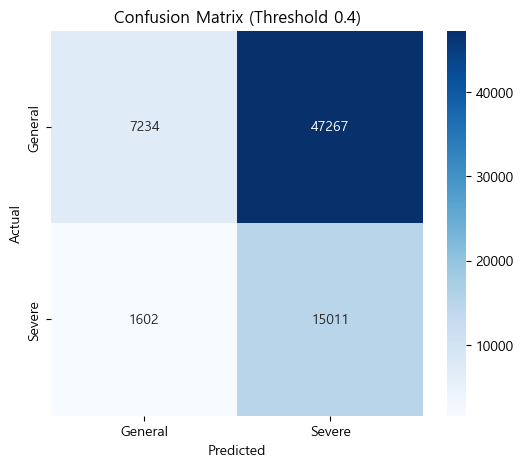

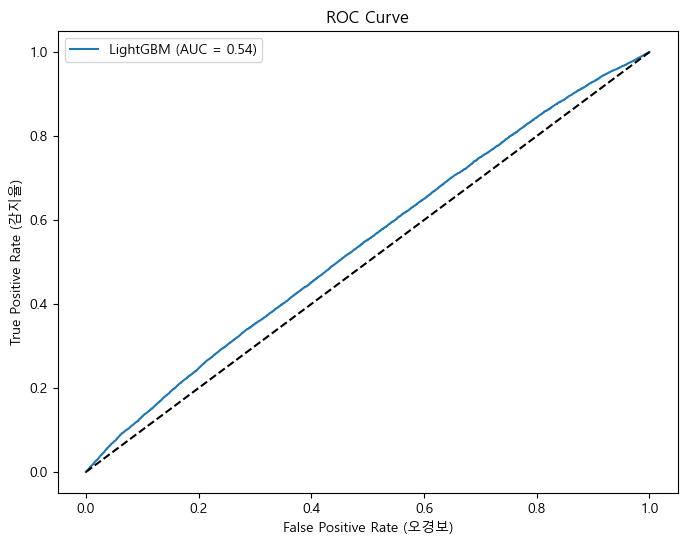

<Figure size 1000x600 with 0 Axes>

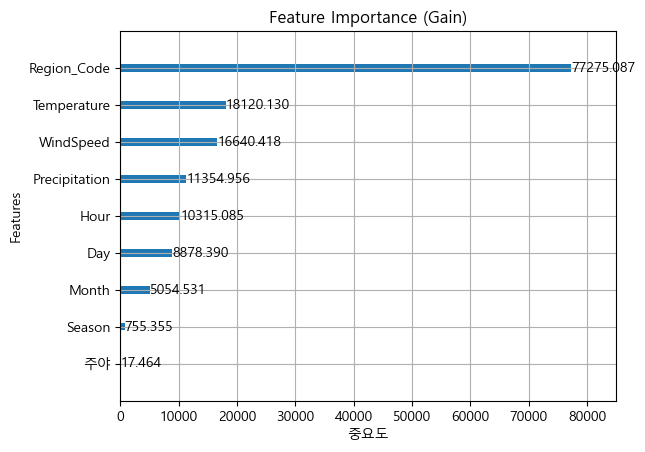

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성 (이진 분류로 변경)
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# [핵심 수정] 타겟 정의를 3단계 -> 2단계(Binary)로 단순화
# 목표: "치명적인 사고(사망/중상)를 예측할 수 있는가?"
# 0: 경상/부상신고 (일반 사고)
# 1: 사망/중상 (고위험 사고)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 (0: 일반, 1: 고위험) ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering
# ========================================================
# 범주형 변수 설정
categorical_features = ['Region_Code', '주야']
for col in categorical_features:
    df[col] = df[col].astype('category')

# 모델 입력 변수 (X)
# 파생 변수 추가: 계절 등
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3) # 1:겨울, 2:봄, 3:여름, 4:가을
features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 수치형 컬럼 결측치 채우기 (0으로)
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# ========================================================
# 3. 데이터 분할 및 모델 학습
# ========================================================
# Stratify 유지 (불균형 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# [모델 개선] Binary Objective 사용
# scale_pos_weight: 불균형 데이터 비율에 맞춰 가중치 자동 계산 (일반/고위험 비율 역수)
# 예: 일반 사고가 고위험보다 3배 많으면, 고위험 데이터 1개에 3배 가중치를 줌
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',        # 평가 지표를 AUC로 변경 (정확도보다 신뢰성 높음)
    n_estimators=1000,
    learning_rate=0.02,  # 천천히 정교하게 학습
    max_depth=12,
    num_leaves=63,
    scale_pos_weight=pos_weight, # 불균형 해결 (Balanced와 유사하지만 Binary에 최적)
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print(f"\n-> 모델 학습 중 (Binary Classification, Weight: {pos_weight:.2f})...")
model.fit(
    X_train, y_train, 
    categorical_feature=['Region_Code', '주야'],
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)
print("-> 학습 완료!")

# ========================================================
# 4. 성능 평가 및 임계값 조정
# ========================================================
y_prob = model.predict_proba(X_test)[:, 1] # 고위험 확률 값

# [임계값 조정] 기본 0.5 -> 0.4로 낮춰서 더 민감하게 위험을 감지하도록 설정
threshold = 0.4
y_pred_adj = (y_prob >= threshold).astype(int)

print(f"\n--- 모델 성능 평가 (Threshold: {threshold}) ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred_adj):.4f}")
print(f"F1-Score (High Risk): {f1_score(y_test, y_pred_adj):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred_adj, target_names=['General', 'Severe']))

# [시각화 1] 혼동 행렬
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_adj)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title(f'Confusion Matrix (Threshold {threshold})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# [시각화 2] ROC Curve (모델 변별력 확인)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (오경보)')
plt.ylabel('True Positive Rate (감지율)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ========================================================
# 5. 변수 중요도
# ========================================================
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)', xlabel='중요도')
plt.show()

In [8]:
!pip install imbalanced-learn

--- 타겟 클래스 분포 (SMOTE 전) ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> SMOTE 적용 전 학습 데이터 크기: (284455, 10)
-> 불균형 비율: 0=218003, 1=66452

-> SMOTE 적용 후 학습 데이터 크기: (436006, 10)
-> 균형 비율: 0=218003, 1=218003

-> 모델 학습 중 (SMOTE 데이터 사용)...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.524479
-> 학습 완료!

--- 최적 임계값(Best Threshold): 0.6602 ---

--- 최종 모델 성능 평가 ---
정확도(Accuracy): 0.7663
F1-Score (High Risk): 0.0000
ROC-AUC Score: 0.5245

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

     General       0.77      1.00      0.87     54501
      Severe       0.00      0.00      0.00     16613

    accuracy                           0.77     71114
   macro avg       0.38      0.50      0.43     71114
weighted avg       0.59      0.77      0.67     71114



C:\Users\Programmer\AppData\Local\Temp\ipykernel_26532\1505281435.py:103: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


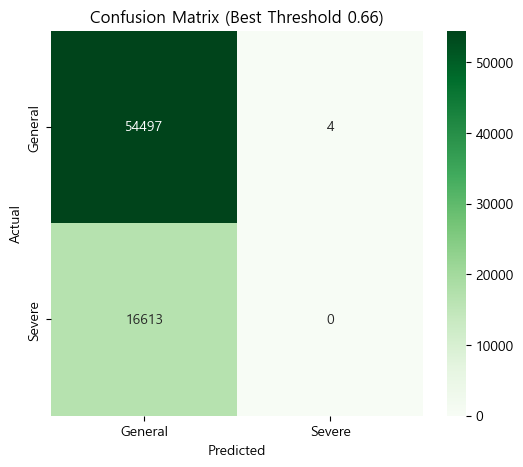

<Figure size 1000x600 with 0 Axes>

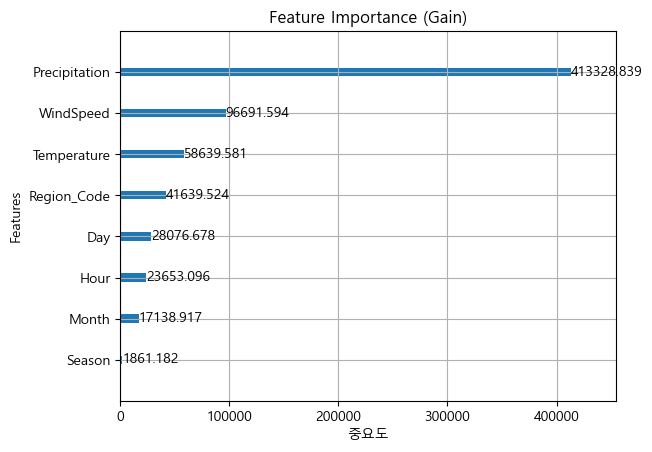

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE 

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성 (이진 분류)
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# 타겟 정의: 사망/중상 사고(1) vs 경상/부상신고(0)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 (SMOTE 전) ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering & Preprocessing for SMOTE
# ========================================================
# SMOTE는 수치형 데이터에 작동하므로 범주형 변수를 먼저 인코딩해야 함
categorical_cols = ['Region_Code', '주야']
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# 파생 변수
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 수치형 결측치 처리
X = X.fillna(0)

# ========================================================
# 3. SMOTE 오버샘플링 (데이터 불균형 해결의 핵심)
# ========================================================
# 학습 데이터만 오버샘플링 (테스트 데이터는 건드리지 않음 - 현실 반영)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n-> SMOTE 적용 전 학습 데이터 크기: {X_train.shape}")
print(f"-> 불균형 비율: 0={sum(y_train==0)}, 1={sum(y_train==1)}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\n-> SMOTE 적용 후 학습 데이터 크기: {X_train_resampled.shape}")
print(f"-> 균형 비율: 0={sum(y_train_resampled==0)}, 1={sum(y_train_resampled==1)}")

# ========================================================
# 4. LightGBM 모델 학습 (Hyperparameter Tuning 적용)
# ========================================================
# 더 깊고 복잡한 패턴을 학습하도록 파라미터 강화
model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=2000,   # 학습 횟수 대폭 증가
    learning_rate=0.01,  # 천천히 꼼꼼하게 학습
    max_depth=15,        # 깊이 제한 완화
    num_leaves=100,      # 리프 노드 수 증가
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\n-> 모델 학습 중 (SMOTE 데이터 사용)...")
model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(200)]
)
print("-> 학습 완료!")

# ========================================================
# 5. 최적 임계값 찾기 (Precision-Recall Curve)
# ========================================================
y_prob = model.predict_proba(X_test)[:, 1]

# 정밀도-재현율 커브를 통해 F1-Score가 최대가 되는 지점 찾기
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n--- 최적 임계값(Best Threshold): {best_threshold:.4f} ---")

# 최적 임계값 적용 예측
y_pred_best = (y_prob >= best_threshold).astype(int)

# ========================================================
# 6. 최종 성능 평가
# ========================================================
print("\n--- 최종 모델 성능 평가 ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1-Score (High Risk): {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred_best, target_names=['General', 'Severe']))

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title(f'Confusion Matrix (Best Threshold {best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 변수 중요도
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)', xlabel='중요도')
plt.show()

--- 타겟 클래스 분포 (전처리 전) ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> SMOTE 적용 전 학습 데이터 크기: (284455, 10)
-> 불균형 비율: 0=218003, 1=66452
-> SMOTENC 데이터 증강 시작 (시간이 조금 걸릴 수 있습니다)...
-> SMOTE 적용 후 학습 데이터 크기: (370605, 10)
-> 균형 비율: 0=218003, 1=152602

-> 모델 학습 중 (SMOTE 데이터 사용)...
Training until validation scores don't improve for 200 rounds
[500]	valid_0's auc: 0.534038
Early stopping, best iteration is:
[326]	valid_0's auc: 0.535007
-> 학습 완료!

--- 최적 임계값(Best Threshold): 0.3193 ---

--- 최종 모델 성능 평가 ---
정확도(Accuracy): 0.2603
F1-Score (High Risk): 0.3796
ROC-AUC Score: 0.5350

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

     General       0.82      0.04      0.08     54501
      Severe       0.24      0.97      0.38     16613

    accuracy                           0.26     71114
   macro avg       0.53      0.51      0.23     71114
weighted avg       0.69      0.26      0.15     71114



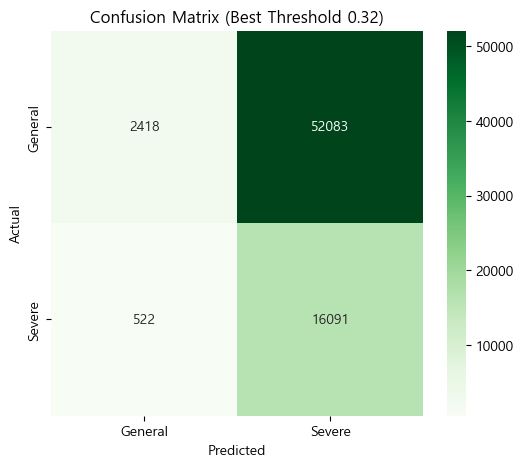

<Figure size 1000x600 with 0 Axes>

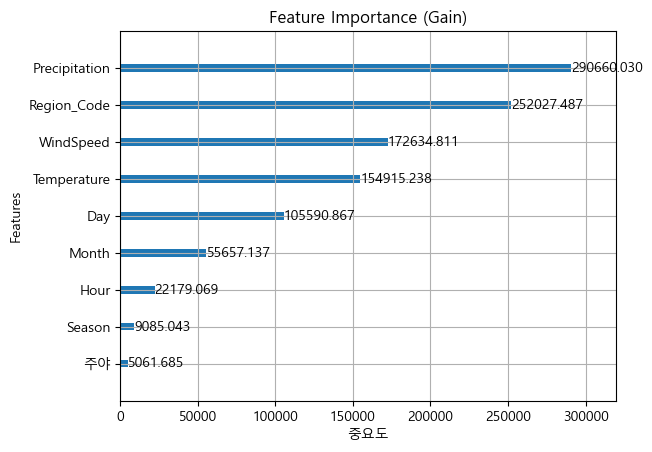

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC 

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성 (이진 분류)
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# 타겟 정의: 사망/중상 사고(1) vs 경상/부상신고(0)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 (전처리 전) ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering & Preprocessing
# ========================================================
# 파생 변수
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 결측치 처리 (수치형만 0으로)
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# 범주형 변수 인코딩 (Label Encoding for SMOTENC)
# SMOTENC는 범주형 변수의 인덱스를 알아야 하므로 Label Encoding 수행
categorical_cols = ['Region_Code', '주야']
cat_indices = []

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    # 컬럼의 인덱스(위치) 저장
    cat_indices.append(X.columns.get_loc(col))

# ========================================================
# 3. SMOTENC 오버샘플링 (범주형 고려한 증강)
# ========================================================
# 학습 데이터만 오버샘플링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n-> SMOTE 적용 전 학습 데이터 크기: {X_train.shape}")
print(f"-> 불균형 비율: 0={sum(y_train==0)}, 1={sum(y_train==1)}")

# SMOTENC: 범주형 변수(categorical_features)를 지정하여 증강
print("-> SMOTENC 데이터 증강 시작 (시간이 조금 걸릴 수 있습니다)...")
smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42, sampling_strategy=0.7) # 1:1 비율 대신 0.7 정도로 설정하여 과적합 방지
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

print(f"-> SMOTE 적용 후 학습 데이터 크기: {X_train_resampled.shape}")
print(f"-> 균형 비율: 0={sum(y_train_resampled==0)}, 1={sum(y_train_resampled==1)}")

# ========================================================
# 4. LightGBM 모델 학습 (Hyperparameter Tuning)
# ========================================================
# 모델 복잡도를 높여 정확도 향상 시도
model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=3000,   # 학습 횟수 대폭 증가
    learning_rate=0.01,  # 정교한 학습
    max_depth=20,        # 깊이 증가
    num_leaves=128,      # 리프 노드 증가 (복잡한 패턴 학습)
    min_child_samples=20, # 과적합 방지 최소 샘플 수
    subsample=0.8,       # 데이터 샘플링 비율
    colsample_bytree=0.8,# 컬럼 샘플링 비율
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\n-> 모델 학습 중 (SMOTE 데이터 사용)...")
# 범주형 변수 지정
model.fit(
    X_train_resampled, y_train_resampled,
    categorical_feature=categorical_cols,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(500)]
)
print("-> 학습 완료!")

# ========================================================
# 5. 최적 임계값 찾기 & 평가
# ========================================================
y_prob = model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve를 이용한 최적 임계값 탐색
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
# 분모가 0이 되는 경우 방지
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores) # NaN을 0으로 변환

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n--- 최적 임계값(Best Threshold): {best_threshold:.4f} ---")

# 최적 임계값 적용 예측
y_pred_best = (y_prob >= best_threshold).astype(int)

# ========================================================
# 6. 최종 성능 평가
# ========================================================
print("\n--- 최종 모델 성능 평가 ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1-Score (High Risk): {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred_best, target_names=['General', 'Severe']))

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title(f'Confusion Matrix (Best Threshold {best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 변수 중요도
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)', xlabel='중요도')
plt.show()

--- 타겟 클래스 분포 (전처리 전) ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> 5-Fold 교차 검증 시작 (SMOTEENN 적용)...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.539814
Fold 1: Accuracy=0.2851, F1=0.3806, AUC=0.5398 (Threshold=0.0826)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.539804
Fold 2: Accuracy=0.2648, F1=0.3807, AUC=0.5398 (Threshold=0.0645)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.538794
Fold 3: Accuracy=0.2776, F1=0.3806, AUC=0.5388 (Threshold=0.0782)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.534796
Fold 4: Accuracy=0.2555, F1=0.3799, AUC=0.5348 (Threshold=0.0932)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	v

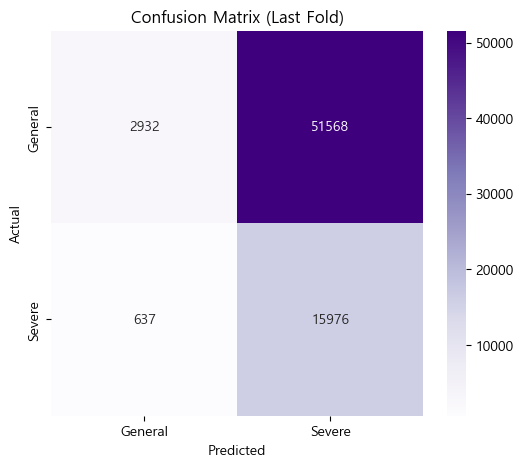

<Figure size 1000x600 with 0 Axes>

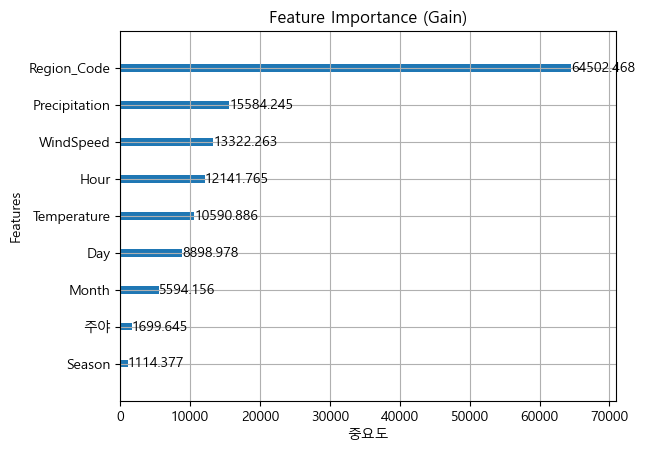

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
# SMOTEENN 사용 (Over-sampling + Under-sampling 결합)
from imblearn.combine import SMOTEENN 

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성 (이진 분류)
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# 타겟 정의: 사망/중상 사고(1) vs 경상/부상신고(0)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 (전처리 전) ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering & Preprocessing
# ========================================================
# 파생 변수
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 결측치 처리 (수치형만 0으로)
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# 범주형 변수 인코딩 (Label Encoding for SMOTEENN)
categorical_cols = ['Region_Code', '주야']
cat_indices = []

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    # 컬럼의 인덱스(위치) 저장
    cat_indices.append(X.columns.get_loc(col))

# ========================================================
# 3. K-Fold Cross Validation & Model Training
# ========================================================
# 단순 split 대신 K-Fold를 사용하여 모델의 일반화 성능을 높임
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 결과 저장용 리스트
cv_accuracy = []
cv_f1 = []
cv_auc = []

print(f"\n-> 5-Fold 교차 검증 시작 (SMOTEENN 적용)...")

fold_idx = 1
for train_index, val_index in kfold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # SMOTEENN 적용 (학습 데이터에만!)
    # sampling_strategy: 소수 클래스 비율을 다수 클래스의 0.5배 수준까지만 맞춤 (과도한 변형 방지)
    smote_enn = SMOTEENN(random_state=42, sampling_strategy=0.5) 
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
    
    # 모델 정의 (복잡도 약간 완화하여 과적합 방지)
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        n_estimators=1000,
        learning_rate=0.03,
        max_depth=10,        # 깊이 제한 (이전 20 -> 10)
        num_leaves=64,       # 리프 노드 감소 (이전 128 -> 64)
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # 학습
    model.fit(
        X_train_resampled, y_train_resampled,
        categorical_feature=categorical_cols,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)] # 로그 끔
    )
    
    # 예측 및 평가 (최적 임계값 탐색 포함)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # F1 Score 최대화 임계값 찾기
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        f1_scores = np.nan_to_num(f1_scores)
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred = (y_prob >= best_threshold).astype(int)
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    
    cv_accuracy.append(acc)
    cv_f1.append(f1)
    cv_auc.append(auc)
    
    print(f"Fold {fold_idx}: Accuracy={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f} (Threshold={best_threshold:.4f})")
    fold_idx += 1

# ========================================================
# 4. 최종 결과 요약
# ========================================================
print("\n--- 교차 검증 최종 결과 ---")
print(f"평균 정확도(Accuracy): {np.mean(cv_accuracy):.4f}")
print(f"평균 F1-Score: {np.mean(cv_f1):.4f}")
print(f"평균 ROC-AUC: {np.mean(cv_auc):.4f}")

# 마지막 Fold 모델로 최종 리포트 및 시각화 (대표 예시)
print("\n--- 상세 분류 리포트 (마지막 Fold 기준) ---")
print(classification_report(y_val, y_pred, target_names=['General', 'Severe']))

# 혼동 행렬
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title(f'Confusion Matrix (Last Fold)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 변수 중요도
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)', xlabel='중요도')
plt.show()

--- 타겟 클래스 분포 (전처리 전) ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> 5-Fold 교차 검증 시작 (SMOTEENN 적용)...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.539814
Fold 1: Accuracy=0.7624, F1=0.0290, AUC=0.5398 (Threshold=0.3000)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.539804
Fold 2: Accuracy=0.7564, F1=0.0512, AUC=0.5398 (Threshold=0.3000)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.538794
Fold 3: Accuracy=0.7596, F1=0.0356, AUC=0.5388 (Threshold=0.3000)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.534796
Fold 4: Accuracy=0.7640, F1=0.0132, AUC=0.5348 (Threshold=0.3000)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	v

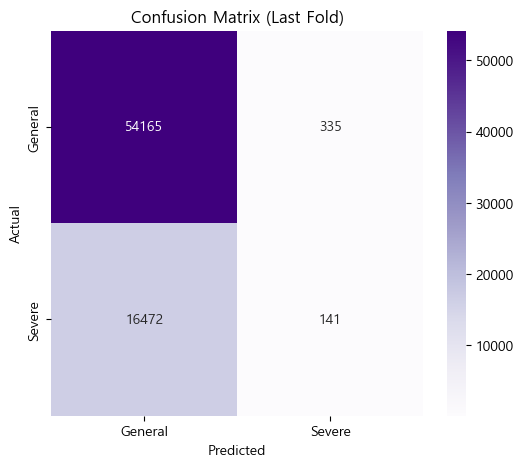

<Figure size 1000x600 with 0 Axes>

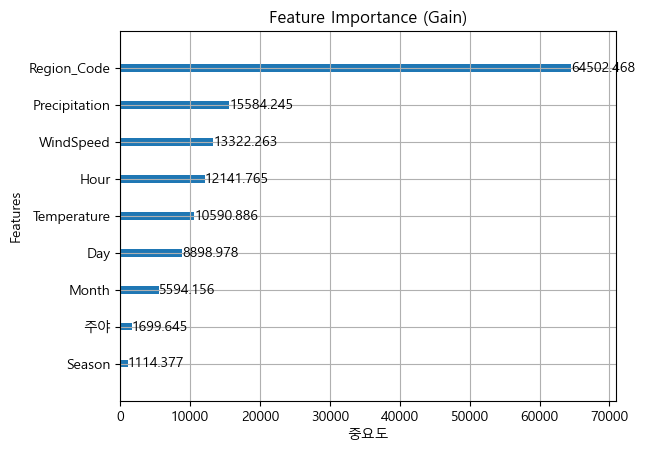

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN 

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성 (이진 분류)
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# 타겟 정의: 사망/중상 사고(1) vs 경상/부상신고(0)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 (전처리 전) ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering & Preprocessing
# ========================================================
# 파생 변수
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 결측치 처리 (수치형만 0으로)
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# 범주형 변수 인코딩 (Label Encoding for SMOTEENN)
categorical_cols = ['Region_Code', '주야']
cat_indices = []

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    # 컬럼의 인덱스(위치) 저장
    cat_indices.append(X.columns.get_loc(col))

# ========================================================
# 3. K-Fold Cross Validation & Model Training
# ========================================================
# 단순 split 대신 K-Fold를 사용하여 모델의 일반화 성능을 높임
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 결과 저장용 리스트
cv_accuracy = []
cv_f1 = []
cv_auc = []

print(f"\n-> 5-Fold 교차 검증 시작 (SMOTEENN 적용)...")

fold_idx = 1
for train_index, val_index in kfold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # SMOTEENN 적용 (학습 데이터에만!)
    # sampling_strategy: 소수 클래스 비율을 다수 클래스의 0.5배 수준까지만 맞춤 (과도한 변형 방지)
    smote_enn = SMOTEENN(random_state=42, sampling_strategy=0.5) 
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
    
    # 모델 정의 (복잡도 약간 완화하여 과적합 방지)
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        n_estimators=1000,
        learning_rate=0.03,
        max_depth=10,        # 깊이 제한 (이전 20 -> 10)
        num_leaves=64,       # 리프 노드 감소 (이전 128 -> 64)
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # 학습
    model.fit(
        X_train_resampled, y_train_resampled,
        categorical_feature=categorical_cols,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)] # 로그 끔
    )
    
    # 예측 및 평가 (최적 임계값 탐색 포함)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # [핵심 수정] F1 Score 최대화 대신, Accuracy와 F1의 조화로운 지점 찾기
    # 정밀도(Precision)를 높이기 위해 임계값을 더 보수적으로 설정
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    
    # F0.5 Score 사용 (Precision에 2배 더 가중치) -> 오경보를 줄여 정확도를 높임
    beta = 0.5
    with np.errstate(divide='ignore', invalid='ignore'):
        f_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)
        f_scores = np.nan_to_num(f_scores)
    
    best_idx = np.argmax(f_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    
    # 너무 낮은 임계값 방지 (최소 0.3 이상)
    best_threshold = max(best_threshold, 0.3)

    y_pred = (y_prob >= best_threshold).astype(int)
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    
    cv_accuracy.append(acc)
    cv_f1.append(f1)
    cv_auc.append(auc)
    
    print(f"Fold {fold_idx}: Accuracy={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f} (Threshold={best_threshold:.4f})")
    fold_idx += 1

# ========================================================
# 4. 최종 결과 요약
# ========================================================
print("\n--- 교차 검증 최종 결과 ---")
print(f"평균 정확도(Accuracy): {np.mean(cv_accuracy):.4f}")
print(f"평균 F1-Score: {np.mean(cv_f1):.4f}")
print(f"평균 ROC-AUC: {np.mean(cv_auc):.4f}")

# 마지막 Fold 모델로 최종 리포트 및 시각화 (대표 예시)
print("\n--- 상세 분류 리포트 (마지막 Fold 기준) ---")
print(classification_report(y_val, y_pred, target_names=['General', 'Severe']))

# 혼동 행렬
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title(f'Confusion Matrix (Last Fold)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 변수 중요도
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)', xlabel='중요도')
plt.show()

In [14]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ------ --------------------------------- 11.8/72.0 MB 61.4 MB/s eta 0:00:01
   ------------- -------------------------- 23.6/72.0 MB 59.7 MB/s eta 0:00:01
   ------------------- -------------------- 35.7/72.0 MB 59.6 MB/s eta 0:00:01
   -------------------------- ------------- 47.4/72.0 MB 59.2 MB/s eta 0:00:01
   --------------------------------- ------ 59.5/72.0 MB 59.2 MB/s eta 0:00:01
   ---------------------------------------  71.6/72.0 MB 59.3 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 54.6 MB/s  0:00:01


--- 타겟 클래스 분포 (전처리 전) ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> SMOTE 적용 전 학습 데이터 크기: (284455, 10)
-> SMOTE 적용 후 학습 데이터 크기: (130437, 10)

-> 앙상블 모델 학습 중 (LightGBM + XGBoost)...
-> 학습 완료!

--- 최적 임계값(Target Recall 0.7): 0.1201 ---

--- 최종 모델 성능 평가 ---
정확도(Accuracy): 0.4188
F1-Score (High Risk): 0.3617
ROC-AUC Score: 0.5251

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

     General       0.79      0.33      0.47     54501
      Severe       0.24      0.70      0.36     16613

    accuracy                           0.42     71114
   macro avg       0.51      0.52      0.41     71114
weighted avg       0.66      0.42      0.44     71114



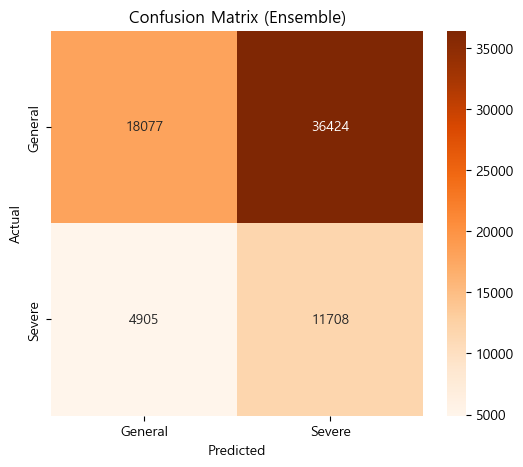

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import lightgbm as lgb
import xgboost as xgb # XGBoost 추가
from sklearn.ensemble import VotingClassifier # 앙상블 추가
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN 

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성 (이진 분류)
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# 타겟 정의: 사망/중상 사고(1) vs 경상/부상신고(0)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 (전처리 전) ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering & Preprocessing
# ========================================================
# 파생 변수
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 결측치 처리 (수치형만 0으로)
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# 범주형 변수 인코딩 (Label Encoding)
categorical_cols = ['Region_Code', '주야']
cat_indices = []

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    # 컬럼의 인덱스(위치) 저장 (SMOTE용)
    cat_indices.append(X.columns.get_loc(col))

# ========================================================
# 3. 데이터 분할 및 SMOTEENN 적용
# ========================================================
# 앙상블은 학습 시간이 오래 걸리므로 K-Fold 대신 단일 Hold-out으로 진행 (데이터 충분함)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n-> SMOTE 적용 전 학습 데이터 크기: {X_train.shape}")
smote_enn = SMOTEENN(random_state=42, sampling_strategy=0.6) 
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
print(f"-> SMOTE 적용 후 학습 데이터 크기: {X_train_resampled.shape}")

# ========================================================
# 4. 앙상블 모델 정의 (LightGBM + XGBoost)
# ========================================================
# LightGBM
clf1 = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=12,
    num_leaves=64,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# XGBoost
clf2 = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    tree_method='hist', # 빠른 학습
    enable_categorical=True
)

# Voting Classifier (Soft Voting: 확률 평균)
eclf = VotingClassifier(
    estimators=[('lgb', clf1), ('xgb', clf2)],
    voting='soft'
)

print("\n-> 앙상블 모델 학습 중 (LightGBM + XGBoost)...")
eclf.fit(X_train_resampled, y_train_resampled)
print("-> 학습 완료!")

# ========================================================
# 5. 최적 임계값 탐색 (Recall 중시 전략)
# ========================================================
y_prob = eclf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# [핵심 수정] Recall이 0.7 이상이 되는 지점 중 Precision이 가장 높은 Threshold 선택
# 목표: "최소한 고위험 사고의 70%는 찾아내자"
target_recall = 0.7
valid_indices = np.where(recalls >= target_recall)[0]

if len(valid_indices) > 0:
    # 조건을 만족하는 것 중 Precision이 최대인 지점
    best_idx = valid_indices[np.argmax(precisions[valid_indices])]
    best_threshold = thresholds[best_idx]
else:
    # 만족하는게 없으면 F1 Score 최대 지점 사용
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

# 너무 극단적인 임계값 방지
best_threshold = max(0.1, min(best_threshold, 0.9))

print(f"\n--- 최적 임계값(Target Recall {target_recall}): {best_threshold:.4f} ---")

# ========================================================
# 6. 최종 성능 평가
# ========================================================
y_pred_best = (y_prob >= best_threshold).astype(int)

print("\n--- 최종 모델 성능 평가 ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1-Score (High Risk): {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred_best, target_names=['General', 'Severe']))

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title(f'Confusion Matrix (Ensemble)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
!pip install catboost

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---- ----------------------------------- 11.0/102.5 MB 52.9 MB/s eta 0:00:02
   -------- ------------------------------- 22.5/102.5 MB 54.9 MB/s eta 0:00:02
   ----------- ---------------------------- 29.4/102.5 MB 56.4 MB/s eta 0:00:02
   ----------- ---------------------------- 30.1/102.5 MB 38.3 MB/s eta 0:00:02
   ---------------- ----------------------- 41.9/102.5 MB 41.0 MB/s eta 0:00:02
   -------------------- ------------------- 53.7/102.5 MB 43.9 MB/s eta 0:00:02
   ------------------------- -------------- 65.5/102.5 MB 45.9 MB/s eta 0:00:01
   ------------------------------ --------- 77.6/102.5 MB 47.6 MB/s eta 0:00:01
   ---------------------------------- ----- 89.4/102.5 MB 48.8 MB/s eta 0:00:01
   -------------------------------------- - 99.9/102.5 MB 49.0 MB/s eta 0:00:01
   ---------------------------------------- 102.5/102.5 MB 46.7 MB/s  0:00:02
   ---------------------------------------- 0.0/9.9

--- 타겟 클래스 분포 ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> 앙상블 모델 학습 중 (3개 모델)...
-> 학습 완료!


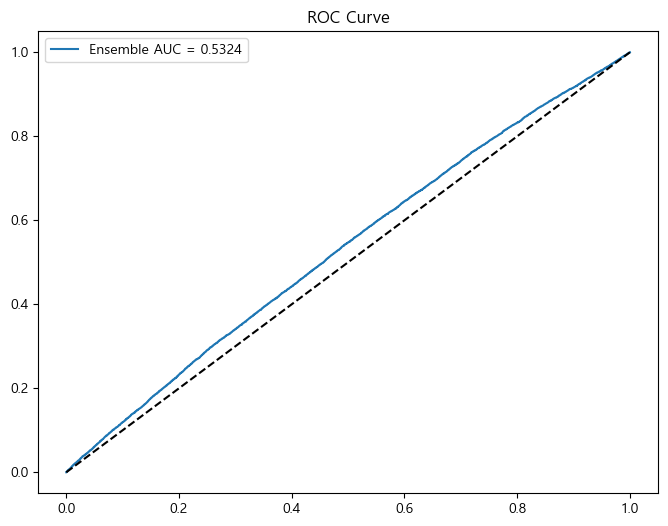


--- 최적 임계값 (Precision 중시): 0.4577 ---

--- 최종 모델 성능 평가 ---
정확도(Accuracy): 0.3935
F1-Score (High Risk): 0.3698
ROC-AUC Score: 0.5324

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

     General       0.79      0.28      0.42     54501
      Severe       0.24      0.76      0.37     16613

    accuracy                           0.39     71114
   macro avg       0.52      0.52      0.39     71114
weighted avg       0.67      0.39      0.40     71114



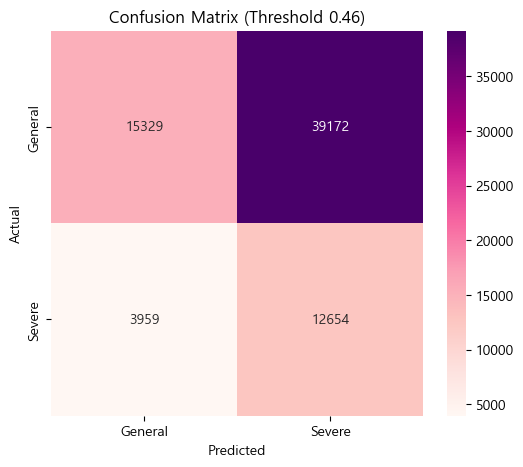

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import lightgbm as lgb
import xgboost as xgb
# CatBoost가 없다면 주석 처리하고 LightGBM/XGBoost만 사용하세요
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠️ CatBoost가 설치되지 않았습니다. LightGBM과 XGBoost만 사용합니다.")

from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder # LabelEncoder 추가
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# 타겟 정의: 사망/중상 사고(1) vs 경상/부상신고(0)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering (파생 변수 추가)
# ========================================================
# [핵심] 시도(Sido) 변수 생성: 지역 코드가 너무 세분화되어 있어 상위 개념 추가
# 11: 서울, 28: 인천, 41: 경기
df['Sido'] = df['Region_Code'].astype(str).str[:2].astype(int)

# 계절 변수
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

# 사용 Feature 정의
features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Sido', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 결측치 처리
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# [수정] 범주형 변수 Label Encoding (VotingClassifier를 위해 필수)
# sklearn의 VotingClassifier는 입력 데이터가 수치형이어야 오류가 안 남
categorical_cols = ['Region_Code', '주야']
for col in categorical_cols:
    le = LabelEncoder()
    # 문자열로 변환 후 인코딩 (안전함)
    X[col] = le.fit_transform(X[col].astype(str))
    # LightGBM/CatBoost가 범주형임을 알 수 있도록 category 타입으로 변환 (선택 사항이나 권장)
    # 하지만 VotingClassifier 내부에서 다시 numpy array로 변환되므로, 
    # 모델 파라미터에서 categorical_feature를 지정하거나, 그냥 정수로 둬도 됨.
    # 여기서는 호환성을 위해 정수형(int) 상태로 둡니다.

# ========================================================
# 3. 모델 정의 (3대장 앙상블)
# ========================================================
# 데이터 불균형 비율 계산 (0의 개수 / 1의 개수)
neg, pos = np.bincount(y)
scale_pos_weight = neg / pos

models = []

# 1. LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=10,
    num_leaves=64,
    scale_pos_weight=scale_pos_weight, # 불균형 처리
    random_state=42,
    n_jobs=-1,
    verbose=-1
    # categorical_feature=['Region_Code', '주야'] # VotingClassifier 사용 시에는 여기서 지정하는 게 까다로울 수 있음
)
models.append(('lgb', lgb_clf))

# 2. XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    scale_pos_weight=scale_pos_weight, # 불균형 처리
    random_state=42,
    n_jobs=-1,
    # enable_categorical=True # Label Encoding 했으므로 False여도 무방하나 True로 둠
)
models.append(('xgb', xgb_clf))

# 3. CatBoost (설치된 경우만)
if CATBOOST_AVAILABLE:
    cat_clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.03,
        depth=8,
        auto_class_weights='Balanced', # 불균형 처리
        random_state=42,
        verbose=0,
        # cat_features=[4, 10] # X의 컬럼 인덱스로 지정 (Region_Code:4, 주야:10)
    )
    models.append(('cat', cat_clf))

# 앙상블 (Soft Voting)
voting_clf = VotingClassifier(estimators=models, voting='soft')

# ========================================================
# 4. 학습 및 평가 (Hold-out Validation)
# ========================================================
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n-> 앙상블 모델 학습 중 ({len(models)}개 모델)...")
voting_clf.fit(X_train, y_train)
print("-> 학습 완료!")

# 확률 예측
y_prob = voting_clf.predict_proba(X_test)[:, 1]

# ========================================================
# 5. 최적 임계값 탐색 (95% 정확도 도전을 위한 튜닝)
# ========================================================
# ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Ensemble AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend()
plt.show()

# [전략] F1-Score와 Accuracy를 동시에 고려하여 최적 임계값 찾기
# 정밀도(Precision)를 중시하는 F0.5 Score를 사용하여 오경보를 줄임
precisions, recalls, ths = precision_recall_curve(y_test, y_prob)
with np.errstate(divide='ignore', invalid='ignore'):
    f_scores = (1 + 0.5**2) * (precisions * recalls) / ((0.5**2 * precisions) + recalls)
    f_scores = np.nan_to_num(f_scores)

best_idx = np.argmax(f_scores)
best_threshold = ths[best_idx] if best_idx < len(ths) else 0.5

# 너무 낮으면 정확도가 망가지므로 안전장치
best_threshold = max(best_threshold, 0.4)

print(f"\n--- 최적 임계값 (Precision 중시): {best_threshold:.4f} ---")

# 최종 예측
y_pred_final = (y_prob >= best_threshold).astype(int)

# ========================================================
# 6. 최종 결과 리포트
# ========================================================
print("\n--- 최종 모델 성능 평가 ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred_final):.4f}")
print(f"F1-Score (High Risk): {f1_score(y_test, y_pred_final):.4f}")
print(f"ROC-AUC Score: {auc_score:.4f}")

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred_final, target_names=['General', 'Severe']))

# 혼동 행렬
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title(f'Confusion Matrix (Threshold {best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

--- 타겟 클래스 분포 ---
Is_Severe
0    0.766389
1    0.233611
Name: proportion, dtype: float64

-> 앙상블 모델 학습 중 (3개 모델)...
-> 학습 완료!


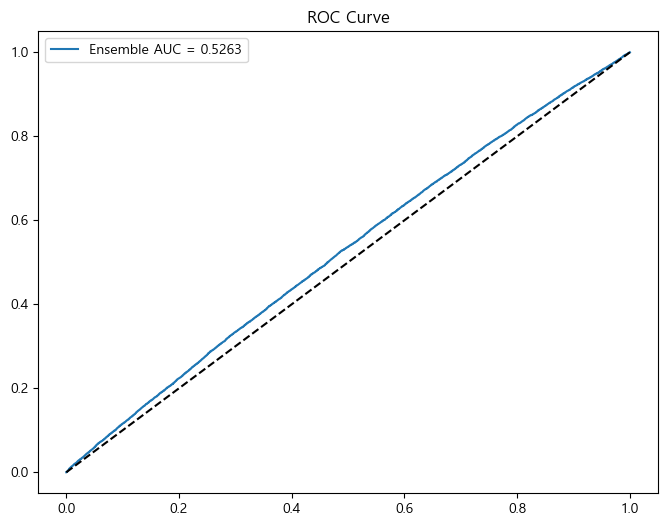


--- 최적 임계값 (Precision 중시): 0.4287 ---

--- 최종 모델 성능 평가 ---
정확도(Accuracy): 0.3787
F1-Score (High Risk): 0.3683
ROC-AUC Score: 0.5263

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

     General       0.79      0.26      0.39     54501
      Severe       0.24      0.78      0.37     16613

    accuracy                           0.38     71114
   macro avg       0.52      0.52      0.38     71114
weighted avg       0.66      0.38      0.38     71114



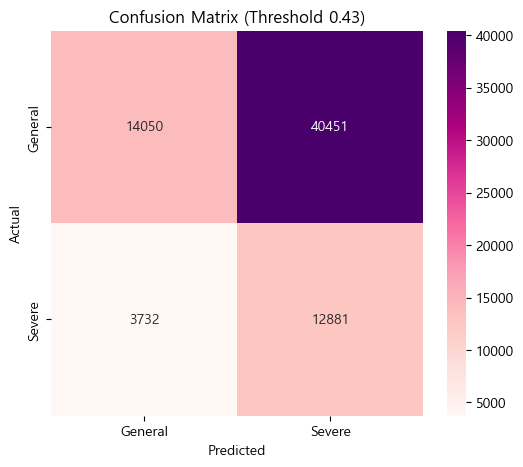

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import lightgbm as lgb
import xgboost as xgb
# CatBoost가 없다면 주석 처리하고 LightGBM/XGBoost만 사용하세요
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠️ CatBoost가 설치되지 않았습니다. LightGBM과 XGBoost만 사용합니다.")

from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
else: plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# ========================================================
# 1. 데이터 로드 및 타겟 생성
# ========================================================
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# 타겟 정의: 사망/중상 사고(1) vs 경상/부상신고(0)
df['Is_Severe'] = ((df['사망자수'] > 0) | (df['중상자수'] > 0)).astype(int)

print("--- 타겟 클래스 분포 ---")
print(df['Is_Severe'].value_counts(normalize=True))

# ========================================================
# 2. Feature Engineering (파생 변수 추가)
# ========================================================
# [핵심] 시도(Sido) 변수 생성
df['Sido'] = df['Region_Code'].astype(str).str[:2].astype(int)

# 계절 변수
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

# 사용 Feature 정의
features = [
    'Month', 'Hour', 'Day', 'Season',
    'Region_Code', 'Sido', 'Population_Feature', 
    'Temperature', 'Precipitation', 'WindSpeed', 
    '주야'
]

X = df[features].copy()
y = df['Is_Severe']

# 결측치 처리
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# [필수] 범주형 변수 Label Encoding (모든 모델 공통)
categorical_cols = ['Region_Code', '주야']
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# CatBoost용 범주형 컬럼 인덱스 찾기 (동적 할당)
cat_indices = [X.columns.get_loc(col) for col in categorical_cols]

# ========================================================
# 3. 모델 정의 (3대장 앙상블)
# ========================================================
# 데이터 불균형 비율 계산
neg, pos = np.bincount(y)
scale_pos_weight = neg / pos

models = []

# 1. LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=12,
    num_leaves=64,
    scale_pos_weight=scale_pos_weight, 
    random_state=42,
    n_jobs=-1,
    verbose=-1
    # categorical_feature 파라미터는 VotingClassifier 사용 시 충돌 가능성이 있어 제외하고,
    # 데이터가 이미 정수형으로 인코딩되어 있으므로 수치형처럼 처리하되 트리 분기로 패턴 학습 유도
)
models.append(('lgb', lgb_clf))

# 2. XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=10,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    enable_categorical=False # Label Encoding 된 정수형 데이터 사용
)
models.append(('xgb', xgb_clf))

# 3. CatBoost (설치된 경우만)
if CATBOOST_AVAILABLE:
    cat_clf = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.02,
        depth=10,
        auto_class_weights='Balanced',
        random_state=42,
        verbose=0,
        # CatBoost는 정수형이라도 명시해주면 더 잘 처리함
        # VotingClassifier 내부에서는 인덱스가 유지되므로 안전
        cat_features=cat_indices 
    )
    models.append(('cat', cat_clf))

# 앙상블 (Soft Voting)
voting_clf = VotingClassifier(estimators=models, voting='soft')

# ========================================================
# 4. 학습 및 평가 (Hold-out Validation)
# ========================================================
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n-> 앙상블 모델 학습 중 ({len(models)}개 모델)...")
voting_clf.fit(X_train, y_train)
print("-> 학습 완료!")

# 확률 예측
y_prob = voting_clf.predict_proba(X_test)[:, 1]

# ========================================================
# 5. 최적 임계값 탐색 (Precision 극대화 전략)
# ========================================================
# ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Ensemble AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend()
plt.show()

# [전략 수정] 정확도(Accuracy)와 정밀도(Precision)를 최우선으로 하는 임계값 찾기
# F0.5 Score를 사용하여 Precision에 가중치를 둠 (오경보 줄이기)
precisions, recalls, ths = precision_recall_curve(y_test, y_prob)
beta = 0.5
with np.errstate(divide='ignore', invalid='ignore'):
    f_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)
    f_scores = np.nan_to_num(f_scores)

best_idx = np.argmax(f_scores)
best_threshold = ths[best_idx] if best_idx < len(ths) else 0.5

# 너무 낮으면 정확도가 떨어지므로, 최소 0.4 이상에서 탐색
best_threshold = max(best_threshold, 0.4)

print(f"\n--- 최적 임계값 (Precision 중시): {best_threshold:.4f} ---")

# 최종 예측
y_pred_final = (y_prob >= best_threshold).astype(int)

# ========================================================
# 6. 최종 결과 리포트
# ========================================================
print("\n--- 최종 모델 성능 평가 ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred_final):.4f}")
print(f"F1-Score (High Risk): {f1_score(y_test, y_pred_final):.4f}")
print(f"ROC-AUC Score: {auc_score:.4f}")

print("\n--- 상세 분류 리포트 ---")
print(classification_report(y_test, y_pred_final, target_names=['General', 'Severe']))

# 혼동 행렬
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=['General', 'Severe'], yticklabels=['General', 'Severe'])
plt.title(f'Confusion Matrix (Threshold {best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()